Epoch 1/10 - Loss: 0.17631
Epoch 2/10 - Loss: 0.14592
Epoch 3/10 - Loss: 0.14246
Epoch 4/10 - Loss: 0.14054
Epoch 5/10 - Loss: 0.13716
Epoch 6/10 - Loss: 0.13390
Epoch 7/10 - Loss: 0.13055
Epoch 8/10 - Loss: 0.12914
Epoch 9/10 - Loss: 0.12739
Epoch 10/10 - Loss: 0.12605


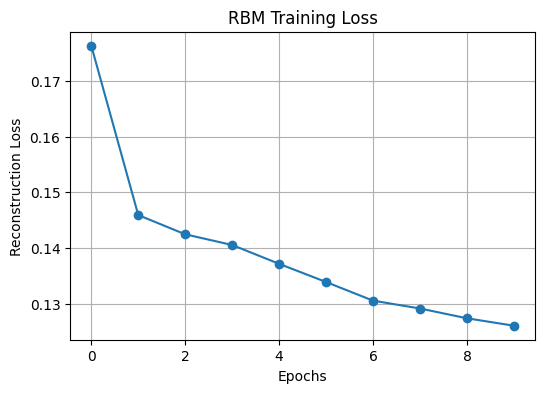

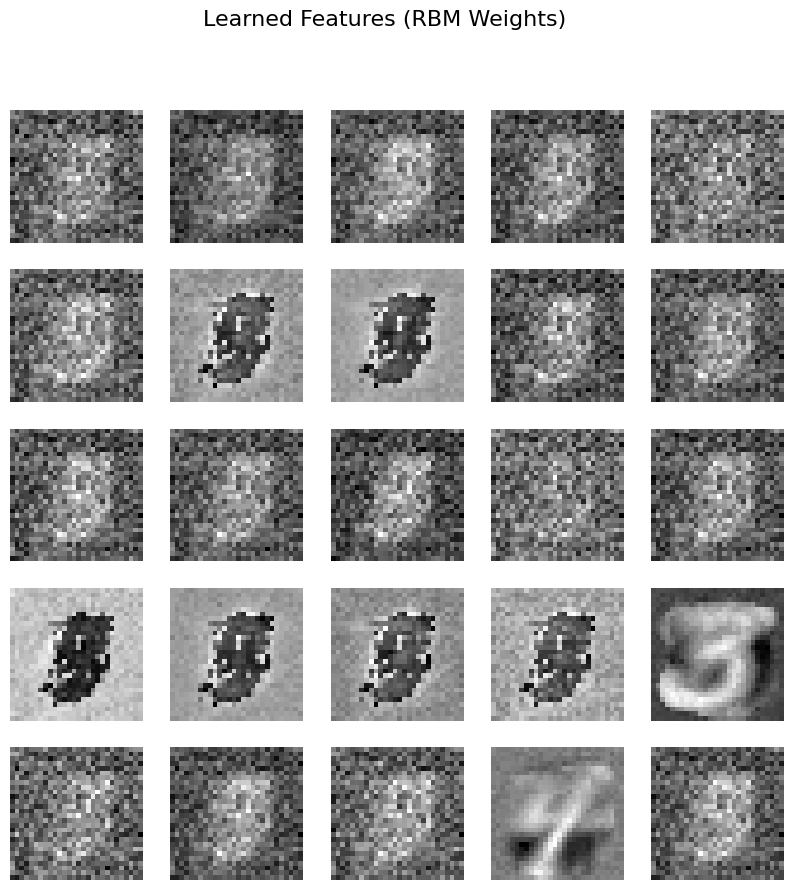

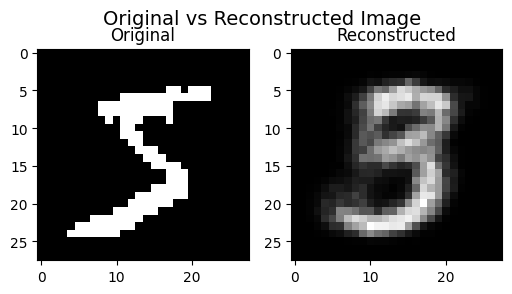

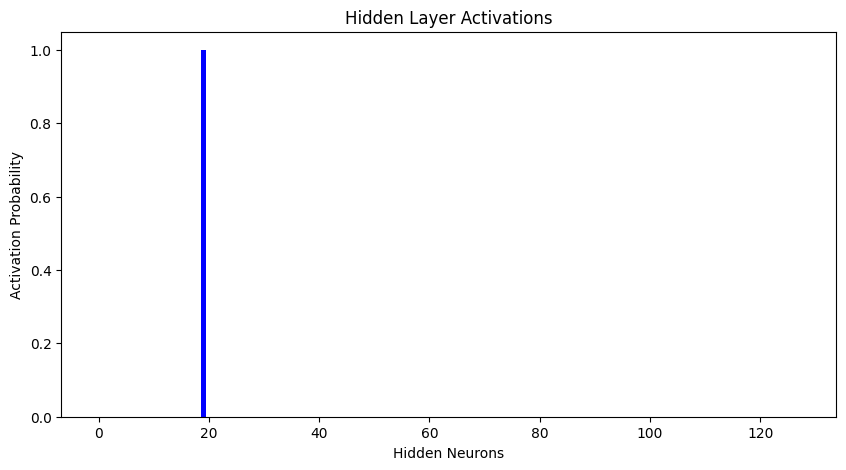

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define RBM
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)  # Weights
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))  # Hidden bias
        self.v_bias = nn.Parameter(torch.zeros(n_visible))  # Visible bias

    def sample_hidden(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return h_prob, torch.bernoulli(h_prob)

    def sample_visible(self, h):
        v_prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return v_prob, torch.bernoulli(v_prob)

    def forward(self, v):
        h_prob, h_sample = self.sample_hidden(v)
        v_prob, v_sample = self.sample_visible(h_sample)
        return v_prob, v_sample

    def contrastive_divergence(self, v, k=1, lr=0.1):
        v_sample = v.clone()
        for _ in range(k):
            _, h_sample = self.sample_hidden(v_sample)
            _, v_sample = self.sample_visible(h_sample)

        h0_prob, h0_sample = self.sample_hidden(v)
        hk_prob, hk_sample = self.sample_hidden(v_sample)

        # Update weights & biases
        self.W.data += lr * (torch.matmul(h0_sample.t(), v) - torch.matmul(hk_sample.t(), v_sample))
        self.v_bias.data += lr * (v - v_sample).mean(dim=0)
        self.h_bias.data += lr * (h0_sample - hk_sample).mean(dim=0)

        # Compute reconstruction loss (for graph)
        loss = torch.mean((v - v_sample) ** 2)
        return loss.item()

    def train_rbm(self, data, epochs=10, batch_size=64, lr=0.1):
        losses = []  # Track loss for visualization
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, data.size(0), batch_size):
                batch = data[i:i + batch_size]
                loss = self.contrastive_divergence(batch, k=1, lr=lr)
                epoch_loss += loss

            avg_loss = epoch_loss / (data.size(0) / batch_size)
            losses.append(avg_loss)
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.5f}")

        # Plot training loss graph
        plt.figure(figsize=(6, 4))
        plt.plot(losses, marker='o', linestyle='-')
        plt.xlabel("Epochs")
        plt.ylabel("Reconstruction Loss")
        plt.title("RBM Training Loss")
        plt.grid(True)
        plt.show()

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
mnist_train = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

# Convert dataset to binary format (0 or 1)
def binarize_data(data):
    return (data > 0.5).float()

data = binarize_data(torch.cat([d[0].view(1, -1) for d in mnist_train], dim=0))  # Ensure 784-dimensional

# Train RBM
rbm = RBM(n_visible=784, n_hidden=128)
rbm.train_rbm(data, epochs=10, batch_size=64, lr=0.1)

# Function to visualize learned weights
def visualize_weights(rbm, num_images=25):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    weights = rbm.W.data.numpy()

    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        img = weights[i].reshape(28, 28)
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    plt.suptitle("Learned Features (RBM Weights)", fontsize=16)
    plt.show()

# Function to reconstruct an image
def reconstruct_image(rbm, sample):
    v_prob, v_sample = rbm.forward(sample)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(sample.view(28, 28), cmap="gray")
    axes[0].set_title("Original")

    axes[1].imshow(v_prob.view(28, 28).detach().numpy(), cmap="gray")
    axes[1].set_title("Reconstructed")

    plt.suptitle("Original vs Reconstructed Image", fontsize=14)
    plt.show()

# Function to visualize hidden activations
def visualize_hidden_activations(rbm, sample):
    h_prob, _ = rbm.sample_hidden(sample)
    h_prob = h_prob.detach().numpy()

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(h_prob)), h_prob, color='blue')
    plt.xlabel("Hidden Neurons")
    plt.ylabel("Activation Probability")
    plt.title("Hidden Layer Activations")
    plt.show()

# Visualize learned weights
visualize_weights(rbm)

# Test image reconstruction
test_sample = data[0]
reconstruct_image(rbm, test_sample)

# Visualize hidden layer activations
visualize_hidden_activations(rbm, test_sample)
